In [2]:
import torch
from torch import nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [3]:
EPOCH = 1    # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 64    
TIME_STEP = 28     # rnn time step / image height
INPUT_SIZE = 28    # rnn input size / image width
LR = 0.01          # learning rate
DOWNLOAD_MNIST = False    # set to True if haven't download the data

In [4]:
train_data = dsets.MNIST(  # 训练数据集
    root='./mnist/',
    train=True,
    transform=transforms.ToTensor(),
    
    download=DOWNLOAD_MNIST,
)

torch.Size([60000, 28, 28])
torch.Size([60000])


D:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
D:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


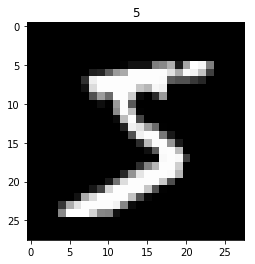

In [5]:
# plot one example
print(train_data.train_data.size())
print(train_data.train_labels.size())
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()    # 黑色的地方值都是0，白色地方值都大于0

In [7]:
# Data Loader for easy mini_batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
# pick 2000 samples to speed up testring
test_data = dsets.MNIST(root='./mnist/', train=False, transform=transforms.ToTensor())  # 测试数据集
test_x = test_data.test_data.type(torch.FloatTensor)[:2000]/255. # shape from (2000, 28, 28) to (2000, 1, 28, 28)
test_y = test_data.test_labels.numpy()[:2000]

D:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
D:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [10]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        
        self.rnn = nn.LSTM(    # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=64,    # rnn hidden unit
            num_layers=1,      # number of rnn layer
            batch_first=True,  # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )
        
        self.out = nn.Linear(64, 10)
        
    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)    # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :]) # (batch,time_step_step,input)
        return out 

In [11]:
rnn = RNN()
print(rnn)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [15]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)    #optomize all ann parameters
loss_func = nn.CrossEntropyLoss()                        # the target label is not one-hotted

In [20]:
# training anf testing
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):    # gives batch size
        b_x = b_x.view(-1, 28, 28)    # reshape x to (batch, time_step, input_size)
        
        output = rnn(b_x)             # rnn output
        
        loss = loss_func(output, b_y) # cross entropy loss
        optimizer.zero_grad()         # clear gradients for next train
        loss.backward()               # backpropagation, compute gradients
        optimizer.step()              # apply gradients
        
        if step % 50 == 0:
            test_output = rnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '|test accuracy: %.2f' % accuracy)

Epoch:  0 | train loss: 2.3091 |test accuracy: 0.12
Epoch:  0 | train loss: 1.0616 |test accuracy: 0.59
Epoch:  0 | train loss: 0.5586 |test accuracy: 0.76
Epoch:  0 | train loss: 0.6470 |test accuracy: 0.86
Epoch:  0 | train loss: 0.3339 |test accuracy: 0.89
Epoch:  0 | train loss: 0.6313 |test accuracy: 0.87
Epoch:  0 | train loss: 0.3175 |test accuracy: 0.91
Epoch:  0 | train loss: 0.1387 |test accuracy: 0.93
Epoch:  0 | train loss: 0.2679 |test accuracy: 0.92
Epoch:  0 | train loss: 0.2803 |test accuracy: 0.93
Epoch:  0 | train loss: 0.2896 |test accuracy: 0.94
Epoch:  0 | train loss: 0.0796 |test accuracy: 0.95
Epoch:  0 | train loss: 0.2160 |test accuracy: 0.95
Epoch:  0 | train loss: 0.1384 |test accuracy: 0.95
Epoch:  0 | train loss: 0.1533 |test accuracy: 0.95
Epoch:  0 | train loss: 0.3631 |test accuracy: 0.96
Epoch:  0 | train loss: 0.2476 |test accuracy: 0.94
Epoch:  0 | train loss: 0.1864 |test accuracy: 0.95
Epoch:  0 | train loss: 0.1846 |test accuracy: 0.96


In [26]:
# print 10 predictions from test data
test_output = rnn(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].data.numpy()
print(pred_y, 'prediction number')
print(test_y[:10], 'real number')

[7 2 1 0 4 1 4 9 6 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number
